# MOVIE ANALYSIS (GENRE AND MONTH)

## **LOADING LIBRARIES AND DATASET**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#supervised algorithms (random forest)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#unsupervised algorithms (kmeans)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#unsupervised algorithms (association rule mining)
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

#one hot encoding
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
movie = pd.read_csv('movie.csv')

print(movie.head()) #first 5 rows
print()
print(movie.info())  #movie info
print()
print(movie.describe)

                              title    imdb_id release_date     budget  \
0  Once Upon a Time... in Hollywood  tt7131622   2019-07-24   95000000   
1                    Pain and Glory  tt8291806   2019-03-22   10769016   
2                            Taxi 5  tt7238392   2017-01-19   20390000   
3                       Wonder Park  tt6428676   2019-03-13  100000000   
4                 The King of Kings  tt7967302   2025-04-07   25200000   

     revenue  tmdb_rating  vote_count  runtimeMinutes  imdb_rating  \
0  392105159        7.426       14234             161          7.6   
1   37359689        7.382        1849             113          7.5   
2   64497208        5.398        1049             102          4.6   
3  119559110        6.529         727              85          5.9   
4   66465461        8.600         102             103          6.8   

   avg_cast_rating  director_rating  writer_rating  composer_rating  \
0             7.35             7.60           7.60             

## **DATA PREPROCESSING**

**Converting release_year to datetime format and exporting the months**

In [ ]:
from datetime import datetime

# Now convert the entire column to datetime safely
movie['release_date'] = pd.to_datetime(movie['release_date'], errors='coerce')

#adding a column to view the month release for each
movie['release_month'] = movie['release_date'].dt.month_name()

#adding a column to view the year release for each
movie['release_year'] = movie['release_date'].dt.year

In [ ]:
movie.columns

Index(['title', 'imdb_id', 'release_date', 'budget', 'revenue', 'tmdb_rating',
       'vote_count', 'runtimeMinutes', 'imdb_rating', 'avg_cast_rating',
       'director_rating', 'writer_rating', 'composer_rating',
       'cinematographer_rating', 'editor_rating', 'genre', 'release_month',
       'release_year'],
      dtype='object')

In [ ]:
movie_df = movie[['title', 'release_month', 'runtimeMinutes', 'genre', 'budget', 'revenue']]

movie_df.head()

,title,release_month,runtimeMinutes,genre,budget,revenue
0,Once Upon a Time... in Hollywood,July,161,"Comedy, Drama, Thriller",95000000,392105159
1,Pain and Glory,March,113,Drama,10769016,37359689
2,Taxi 5,January,102,"Action, Comedy, Crime",20390000,64497208
3,Wonder Park,March,85,"Adventure, Animation, Comedy, Family, Fantasy",100000000,119559110
4,The King of Kings,April,103,"Adventure, Animation, Drama, Family, Fantasy",25200000,66465461


**CONVERTING GENRE TO ONE HOT ENCODING**

In [ ]:
#split the genres into lists
movie_df['genre'] = movie_df['genre'].str.split(',')

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(movie_df['genre']), columns=mlb.classes_, index=movie_df.index)

/tmp/ipython-input-3359392152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['genre'] = movie_df['genre'].str.split(',')


In [ ]:
#combine with original dataframe
movie_df = pd.concat([movie_df, genre_encoded], axis=1)

**CONVERTING MONTHS TO ONE HOT ENCODING**

In [ ]:
# One-hot encode the release month
month_encoded = pd.get_dummies(movie_df['release_month'], prefix='Month')

# Add back to the original dataframe
movie_df = pd.concat([movie_df, month_encoded], axis=1)

## **DATA EXPLORATION USING ALGORITHMS**

In [ ]:
movie_df.columns

Index(['title', 'release_month', 'runtimeMinutes', 'genre', 'budget',
       'revenue', ' Adventure', ' Animation', ' Biography', ' Comedy',
       ' Crime', ' Documentary', ' Drama', ' Family', ' Fantasy', ' History',
       ' Horror', ' Music', ' Musical', ' Mystery', ' Romance', ' Sci-Fi',
       ' Science Fiction', ' Sport', ' Thriller', ' Tv Movie', ' War',
       ' Western', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery',
       'Sci-Fi', 'Thriller', 'Month_April', 'Month_August', 'Month_December',
       'Month_February', 'Month_January', 'Month_July', 'Month_June',
       'Month_March', 'Month_May', 'Month_November', 'Month_October',
       'Month_September'],
      dtype='object')

So to cluster the movies using the features (with emphasis on how block boster, and other movies are released).

In [ ]:
#setting columns i want to find the clusters
df = movie_df[['revenue','budget', ' Adventure', ' Animation', ' Biography', ' Comedy',
       ' Crime', ' Documentary', ' Drama', ' Family', ' Fantasy', ' History',
       ' Horror', ' Music', ' Musical', ' Mystery', ' Romance', ' Sci-Fi',
       ' Science Fiction', ' Sport', ' Thriller', ' Tv Movie', ' War',
       ' Western', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery',
       'Sci-Fi', 'Thriller', 'Month_April', 'Month_August', 'Month_December',
       'Month_February', 'Month_January', 'Month_July', 'Month_June',
       'Month_March', 'Month_May', 'Month_November', 'Month_October',
       'Month_September']]

### **KMEANS ALGORITHM**

**SCALING THE REVENUE AND BUDGET**

In [ ]:
#scaling numeric features (to expose the outliers clearly)
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['revenue', 'budget']] = scaler.fit_transform(df_scaled[['revenue', 'budget']])

In [ ]:
print(df_scaled)


       revenue    budget   Adventure   Animation   Biography   Comedy   Crime  \
0     1.165293  0.894435           0           0           0        0       0   
1    -0.268900 -0.528509           0           0           0        0       0   
2    -0.159187 -0.365979           0           0           0        1       1   
3     0.063422  0.978902           0           1           0        1       0   
4    -0.151229 -0.284721           0           1           0        0       0   
...        ...       ...         ...         ...         ...      ...     ...   
1368 -0.419941 -0.486212           0           0           0        0       0   
1369 -0.419941 -0.709505           0           0           0        0       0   
1370 -0.349743 -0.659754           0           0           0        0       0   
1371 -0.419941 -0.710181           0           0           0        1       0   
1372 -0.419941 -0.709826           1           0           0        1       0   

       Documentary   Drama 

Scaling instead of minmax to properly visualize the outliers (block buster movies)

**APPLYING KMEANS ALGORITHM**

In [ ]:
#applying kmeans algorithm
kmeans = KMeans(n_clusters=3, random_state=42)
movie_df['cluster'] = kmeans.fit_predict(df_scaled)

In [ ]:
print(movie_df[['title', 'revenue', 'cluster']])

                                 title    revenue  cluster
0     Once Upon a Time... in Hollywood  392105159        0
1                       Pain and Glory   37359689        1
2                               Taxi 5   64497208        1
3                          Wonder Park  119559110        1
4                    The King of Kings   66465461        0
...                                ...        ...      ...
1368                       Io Capitano          0        0
1369                         The Dunes          0        1
1370                              Fall   17363261        1
1371         Glossary of Broken Dreams          0        0
1372                  The VelociPastor          0        1

[1373 rows x 3 columns]


In [ ]:
#inspecting cluster by their average
cluster_avg = movie_df.groupby('cluster')['revenue'].mean()
print(cluster_avg)

cluster
0    3.439339e+07
1    4.862925e+07
2    6.144514e+08
Name: revenue, dtype: float64


In [ ]:
#find cluster with higest average revenue
highest_avg_cluster = cluster_avg.idxmax()

#subset the dataframe
high_rev_movies = movie_df[movie_df['cluster'] == highest_avg_cluster]

print(f'Cluster with the highest average revenue: {highest_avg_cluster}')

Cluster with the highest average revenue: 2


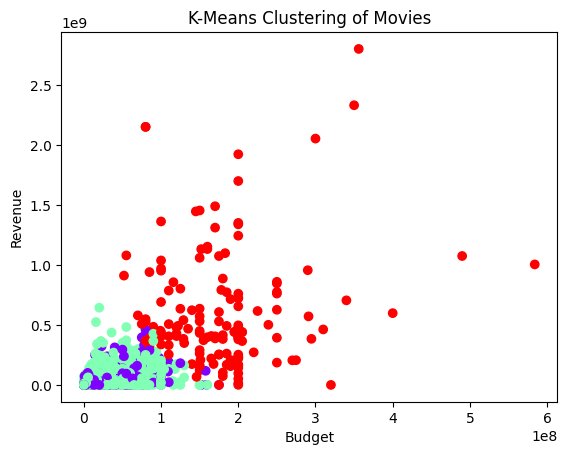

In [ ]:
#visualizing the clusters
plt.scatter(movie_df['budget'], movie_df['revenue'], c=movie_df['cluster'], cmap='rainbow')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('K-Means Clustering of Movies')
plt.show()

From the visualization, we can see the outliers very clearly as very large values where grouped into one cluster.

Analyzing only cluster 2 (high earning movies or outliers in this case). Hence we can drop budget and revenue since we already know they have high in both and association rule does not accept partial values(must be 1 0r 0, true or false)

### **ASSOCIATION RULE MINING**

**HANDLING OUTLIERS FIRST (HIGH BUDGET AND REVENUE MOVIE)**

To determine the studio release for genres according to month

In [ ]:
#obtaining only features already encoded
rule_feature_1 = df_scaled.loc[high_rev_movies.index]

#removing budget and revenue
rule_feature_1 = rule_feature_1.drop(columns=['budget', 'revenue'])
rule_feature_1. head()

,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
8,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
10,1,0,0,1,0,0,0,1,0,0,...,False,False,False,False,False,False,True,False,False,False
11,1,0,0,1,0,0,0,1,0,0,...,True,False,False,False,False,False,False,False,False,False
12,0,0,0,0,0,0,1,0,0,0,...,False,False,False,False,False,False,True,False,False,False
14,1,0,0,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False


**ASSOCIATION RULE MINING for outliers**

In [ ]:
#find frequent itemsets
frequent_items = apriori(rule_feature_1, min_support=0.05, use_colnames=True)

#extract rules
rules = association_rules(frequent_items, metric='lift', min_threshold=1)


rules = rules[rules['consequents'].apply(lambda x: all('Month' in item for item in x))]

/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
#sorting by lift
rules = rules.sort_values(by='lift', ascending=False)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

                                   antecedents       consequents   support  \
427           (Adventure,  Animation,  Comedy)      (Month_June)  0.054795   
529  (Adventure,  Animation,  Family,  Comedy)      (Month_June)  0.054795   
220                    (Adventure,  Animation)      (Month_June)  0.054795   
455           (Adventure,  Animation,  Family)      (Month_June)  0.054795   
208                      ( Animation,  Family)      (Month_June)  0.068493   
399             ( Animation,  Family,  Comedy)      (Month_June)  0.054795   
191                      ( Animation,  Comedy)      (Month_June)  0.054795   
102                     ( Adventure,  Fantasy)  (Month_December)  0.061644   
280                         (Action,  Fantasy)  (Month_December)  0.061644   
333             (Action,  Adventure,  Fantasy)  (Month_December)  0.061644   
484              (Adventure,  Family,  Comedy)      (Month_June)  0.054795   
26                                ( Animation)      (Month_June)

**HANDLING OTHER MOVIE (non-outliers)**

In [ ]:
#working on cluster 1 or 2
rule_feature_2 = movie_df[(movie_df['cluster'] == 1) | (movie_df['cluster'] == 0)]

#removing budget and revenue
rule_feature_2 = rule_feature_2.drop(columns=['budget', 'revenue','title', 'release_month', 'runtimeMinutes', 'genre', 'cluster'])
rule_feature_2. head()

,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,0,0,0,0,0,0,1,0,0,0,...,False,False,False,True,False,False,False,False,False,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2,0,0,0,1,1,0,0,0,0,0,...,False,False,True,False,False,False,False,False,False,False
3,0,1,0,1,0,0,0,1,1,0,...,False,False,False,False,False,True,False,False,False,False
4,0,1,0,0,0,0,1,1,1,0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
#frequent items
frequent_items_2 = apriori(rule_feature_2, min_support=0.05, use_colnames=True)

#extract rules
rules_2 = association_rules(frequent_items_2, metric='lift', min_threshold=1)

# Keep only rules where the consequent is month
rules_2 = rules_2[rules_2['consequents'].apply(lambda x: all('Month' in item for item in x))]

rules_2 = rules_2.sort_values(by='lift', ascending=False)
print(rules_2[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


   antecedents      consequents   support  confidence      lift
19    ( Drama)  (Month_October)  0.051345    0.116022  1.148057


## **COMPARSION OF RULES**

**FOR OUTLIERS**

In [ ]:
# Convert genre and month sets/tuples into strings
rules['genre_combo'] = rules['antecedents'].apply(lambda x: ', '.join(sorted(list(x))))
rules['month_combo'] = rules['consequents'].apply(lambda x: ', '.join(sorted(list(x))))

# Example: top 20 strongest rules
top_rules = rules.sort_values(by='lift', ascending=False).head(20)

**FOR NON-OUTLIERS**

In [ ]:
# Convert genre and month sets/tuples into strings
rules_2['genre_combo'] = rules_2['antecedents'].apply(lambda x: ', '.join(sorted(list(x))))
rules_2['month_combo'] = rules_2['consequents'].apply(lambda x: ', '.join(sorted(list(x))))

# Example: top 20 strongest rules
top_rules_2 = rules_2.sort_values(by='lift', ascending=False).head(20)

**BAR PLOT COMPARISONS**

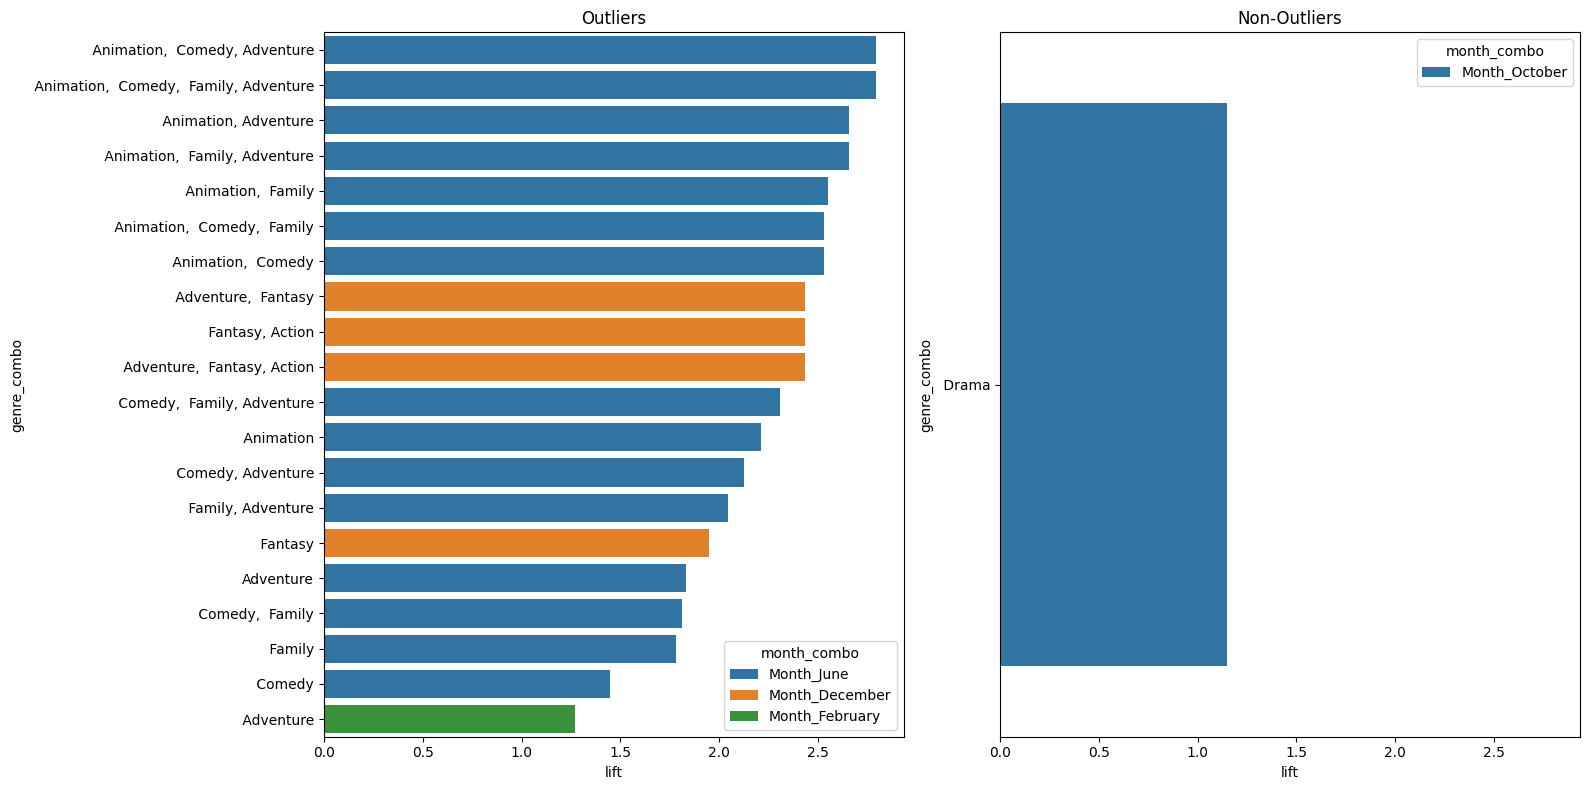

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

sns.barplot(data=top_rules, x='lift', y='genre_combo', hue='month_combo', ax=axes[0])
axes[0].set_title('Outliers')
sns.barplot(data=top_rules_2, x='lift', y='genre_combo', hue='month_combo', ax=axes[1])
axes[1].set_title('Non-Outliers')

plt.tight_layout()
plt.show()


From the bar plot, we observe a clear pattern in the release timing of outlier (high-grossing) movies, whereas for non-outliers, no discernible pattern emerges. This suggests that most movie studios prioritize strategic release dates for high-budget or potentially high-revenue films, while lower-budget movies receive comparatively less planning in their release strategy.

This finding opens the door for further research: it would be valuable to investigate whether a more strategic release schedule for low-budget movies could positively influence their performance. Such research could focus solely on release timing, independent of marketing expenditure, to isolate the effect of strategic scheduling on movie success. Additionally, integrating social media analysis could provide insights into audience trends and preferences, helping studios identify optimal release windows based not only on historical patterns but also on real-time public interest.

The bar plot reveals a clear pattern in the release timing of high-grossing movies, while lower-budget films show no discernible pattern. This suggests that studios strategically plan releases for potential blockbusters but place less emphasis on low-budget movies. Future research could explore whether more strategic release scheduling could improve the performance of lower-budget films, potentially incorporating social media trends to identify optimal release windows based on real-time audience interest.